In [4]:
import airfrans as af
import matplotlib.pyplot as plt

Download the dataset

In [ ]:
# save_path = "C:/Users/hoang/OneDrive/Desktop/NeuIPS_competition"
# af.dataset.download(root = save_path , file_name = "AirfRANS_dataset", unzip = True, OpenFOAM = False)

Load the data

In [5]:
dataset_list, dataset_name = af.dataset.load(root="C:/Users/hoang/OneDrive/Desktop/NeuIPS_competition/Dataset", task='full', train=True)

Loading dataset (task: full, split: train): 100%|██████████| 800/800 [08:14<00:00,  1.62it/s]


Note: the unit is in meter (m)

Each simulation is given as a point cloud defined via the nodes of the simulation mesh. Each point of a point cloud is described via 7 features: the position (position_x, position_y), the inlet velocity (inlet_velocity_u, inlet_velocity_v) in m/s, the distance to the airfoil (distance_to_airfoil) in m, and the normals (normal_x, normal_y) in m, set to 0 if the point is not on the airfoil. ==> 7 features

Each point is given a target of 4 components for the underlying regression task: the velocity (velocity_u, velocity_v) in m/s, the pressure divided by the specific mass (pressure_div_specific_mass) in m^2/s, the turbulent kinematic viscocity (turbulent_kinematic_viscosity) in m^2/s. ==> 4 features

Finally, a boolean is attached to each point to inform if this point lies on the airfoil or not (is_on_airfoil). ==> 1 feature

Total there are 12 features, and the shape (N, 7 + 4 + 1), where N is the number of point in each simulation.

Also, there are name corresponding to each simulation.

https://airfrans.readthedocs.io/en/latest/modules/dataset.html

In [23]:
import numpy as np
import pandas as pd

#Convert to pandas Dataframe
for i in range(0,len(dataset_list)):
    dataset_list[i] = pd.DataFrame(dataset_list[i])


for i in range(10):
    print(f"Shape of the first {i}th simulation: {dataset_list[i].shape}")

print(f"The total simulation in the dataset are: {len(dataset_list)}")

Shape of the first 0th simulation: (181794, 12)
Shape of the first 1th simulation: (170180, 12)
Shape of the first 2th simulation: (163156, 12)
Shape of the first 3th simulation: (180991, 12)
Shape of the first 4th simulation: (189773, 12)
Shape of the first 5th simulation: (180542, 12)
Shape of the first 6th simulation: (180101, 12)
Shape of the first 7th simulation: (179653, 12)
Shape of the first 8th simulation: (179884, 12)
Shape of the first 9th simulation: (187228, 12)
The total simulation in the dataset are: 800


In [27]:
#Rename the column

for i in range(len(dataset_list)):
    dataset_list[i].columns = [
        "position_x", "position_y", "inlet_velocity_u", "inlet_velocity_v", "distance_to_airfoil", "normal_x", "normal_y",
        "velocity_u", "velocity_v", "pressure_div_specific_mass", "turbulent_kinematic_viscosity",
        "is_on_airfoil"
    ]

In [30]:
dataset_list[0].head()

,position_x,position_y,inlet_velocity_u,inlet_velocity_v,distance_to_airfoil,normal_x,normal_y,velocity_u,velocity_v,pressure_div_specific_mass,turbulent_kinematic_viscosity,is_on_airfoil
0,4.215558,0.631122,35.909688,7.187848,3.276908,0.0,0.0,36.027802,6.166214,2.859903,5.030447e-10,0.0
1,4.215571,0.631109,35.909688,7.187848,3.276918,0.0,0.0,36.027802,6.166219,2.860045,5.040390e-10,0.0
2,3.990525,0.586954,35.909688,7.187848,3.047582,0.0,0.0,36.027950,6.103744,3.252359,3.098376e-10,0.0
3,3.990538,0.586942,35.909688,7.187848,3.047593,0.0,0.0,36.027950,6.103749,3.252516,3.120404e-10,0.0
4,3.781193,0.545868,35.909688,7.187848,2.834256,0.0,0.0,36.027172,6.038235,3.692405,1.528453e-10,0.0


Quick summary of the first simulation

In [32]:
dataset_list[0].info(), dataset_list[0].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181794 entries, 0 to 181793
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   position_x                     181794 non-null  float64
 1   position_y                     181794 non-null  float64
 2   inlet_velocity_u               181794 non-null  float64
 3   inlet_velocity_v               181794 non-null  float64
 4   distance_to_airfoil            181794 non-null  float64
 5   normal_x                       181794 non-null  float64
 6   normal_y                       181794 non-null  float64
 7   velocity_u                     181794 non-null  float64
 8   velocity_v                     181794 non-null  float64
 9   pressure_div_specific_mass     181794 non-null  float64
 10  turbulent_kinematic_viscosity  181794 non-null  float64
 11  is_on_airfoil                  181794 non-null  float64
dtypes: float64(12)
memory usage: 1

(None,
           position_x     position_y  inlet_velocity_u  inlet_velocity_v  \
 count  181794.000000  181794.000000      1.817940e+05      1.817940e+05   
 mean        0.500545       0.025287      3.590969e+01      7.187848e+00   
 std         0.701035       0.342164      1.421089e-14      2.664543e-15   
 min        -2.159128      -1.618031      3.590969e+01      7.187848e+00   
 25%        -0.001915      -0.029738      3.590969e+01      7.187848e+00   
 50%         0.447104       0.010029      3.590969e+01      7.187848e+00   
 75%         0.950290       0.080707      3.590969e+01      7.187848e+00   
 max         4.226741       1.613887      3.590969e+01      7.187848e+00   
 
        distance_to_airfoil       normal_x       normal_y     velocity_u  \
 count        181794.000000  181794.000000  181794.000000  181794.000000   
 mean              0.230715       0.001763       0.000137      21.992910   
 std               0.474909       0.044638       0.060354      16.824718   
 mi

In [50]:
#Check if the inlet_velocity is constant

print(dataset_list[0]["inlet_velocity_u"].nunique)
print(dataset_list[0]["inlet_velocity_v"].nunique)

<bound method IndexOpsMixin.nunique of 0         35.909688
1         35.909688
2         35.909688
3         35.909688
4         35.909688
            ...    
181789    35.909688
181790    35.909688
181791    35.909688
181792    35.909688
181793    35.909688
Name: inlet_velocity_u, Length: 181794, dtype: float64>
<bound method IndexOpsMixin.nunique of 0         7.187848
1         7.187848
2         7.187848
3         7.187848
4         7.187848
            ...   
181789    7.187848
181790    7.187848
181791    7.187848
181792    7.187848
181793    7.187848
Name: inlet_velocity_v, Length: 181794, dtype: float64>


<Axes: >

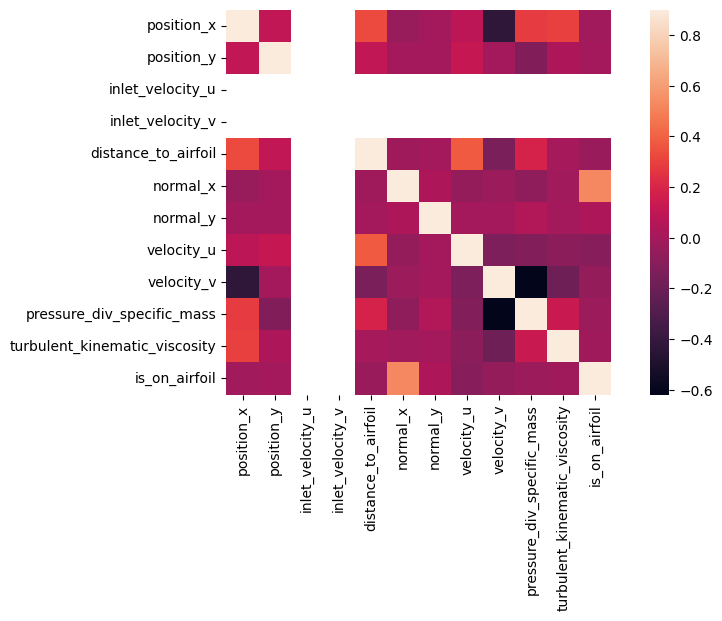

In [52]:
import seaborn as sns

plt.subplots(figsize = (10, 5))
sns.heatmap(dataset_list[0].corr(), vmax = 0.9, square = True)

Since the value of inlet_velocity (u, v) is constant, hence the correlation matrix return N/A value 

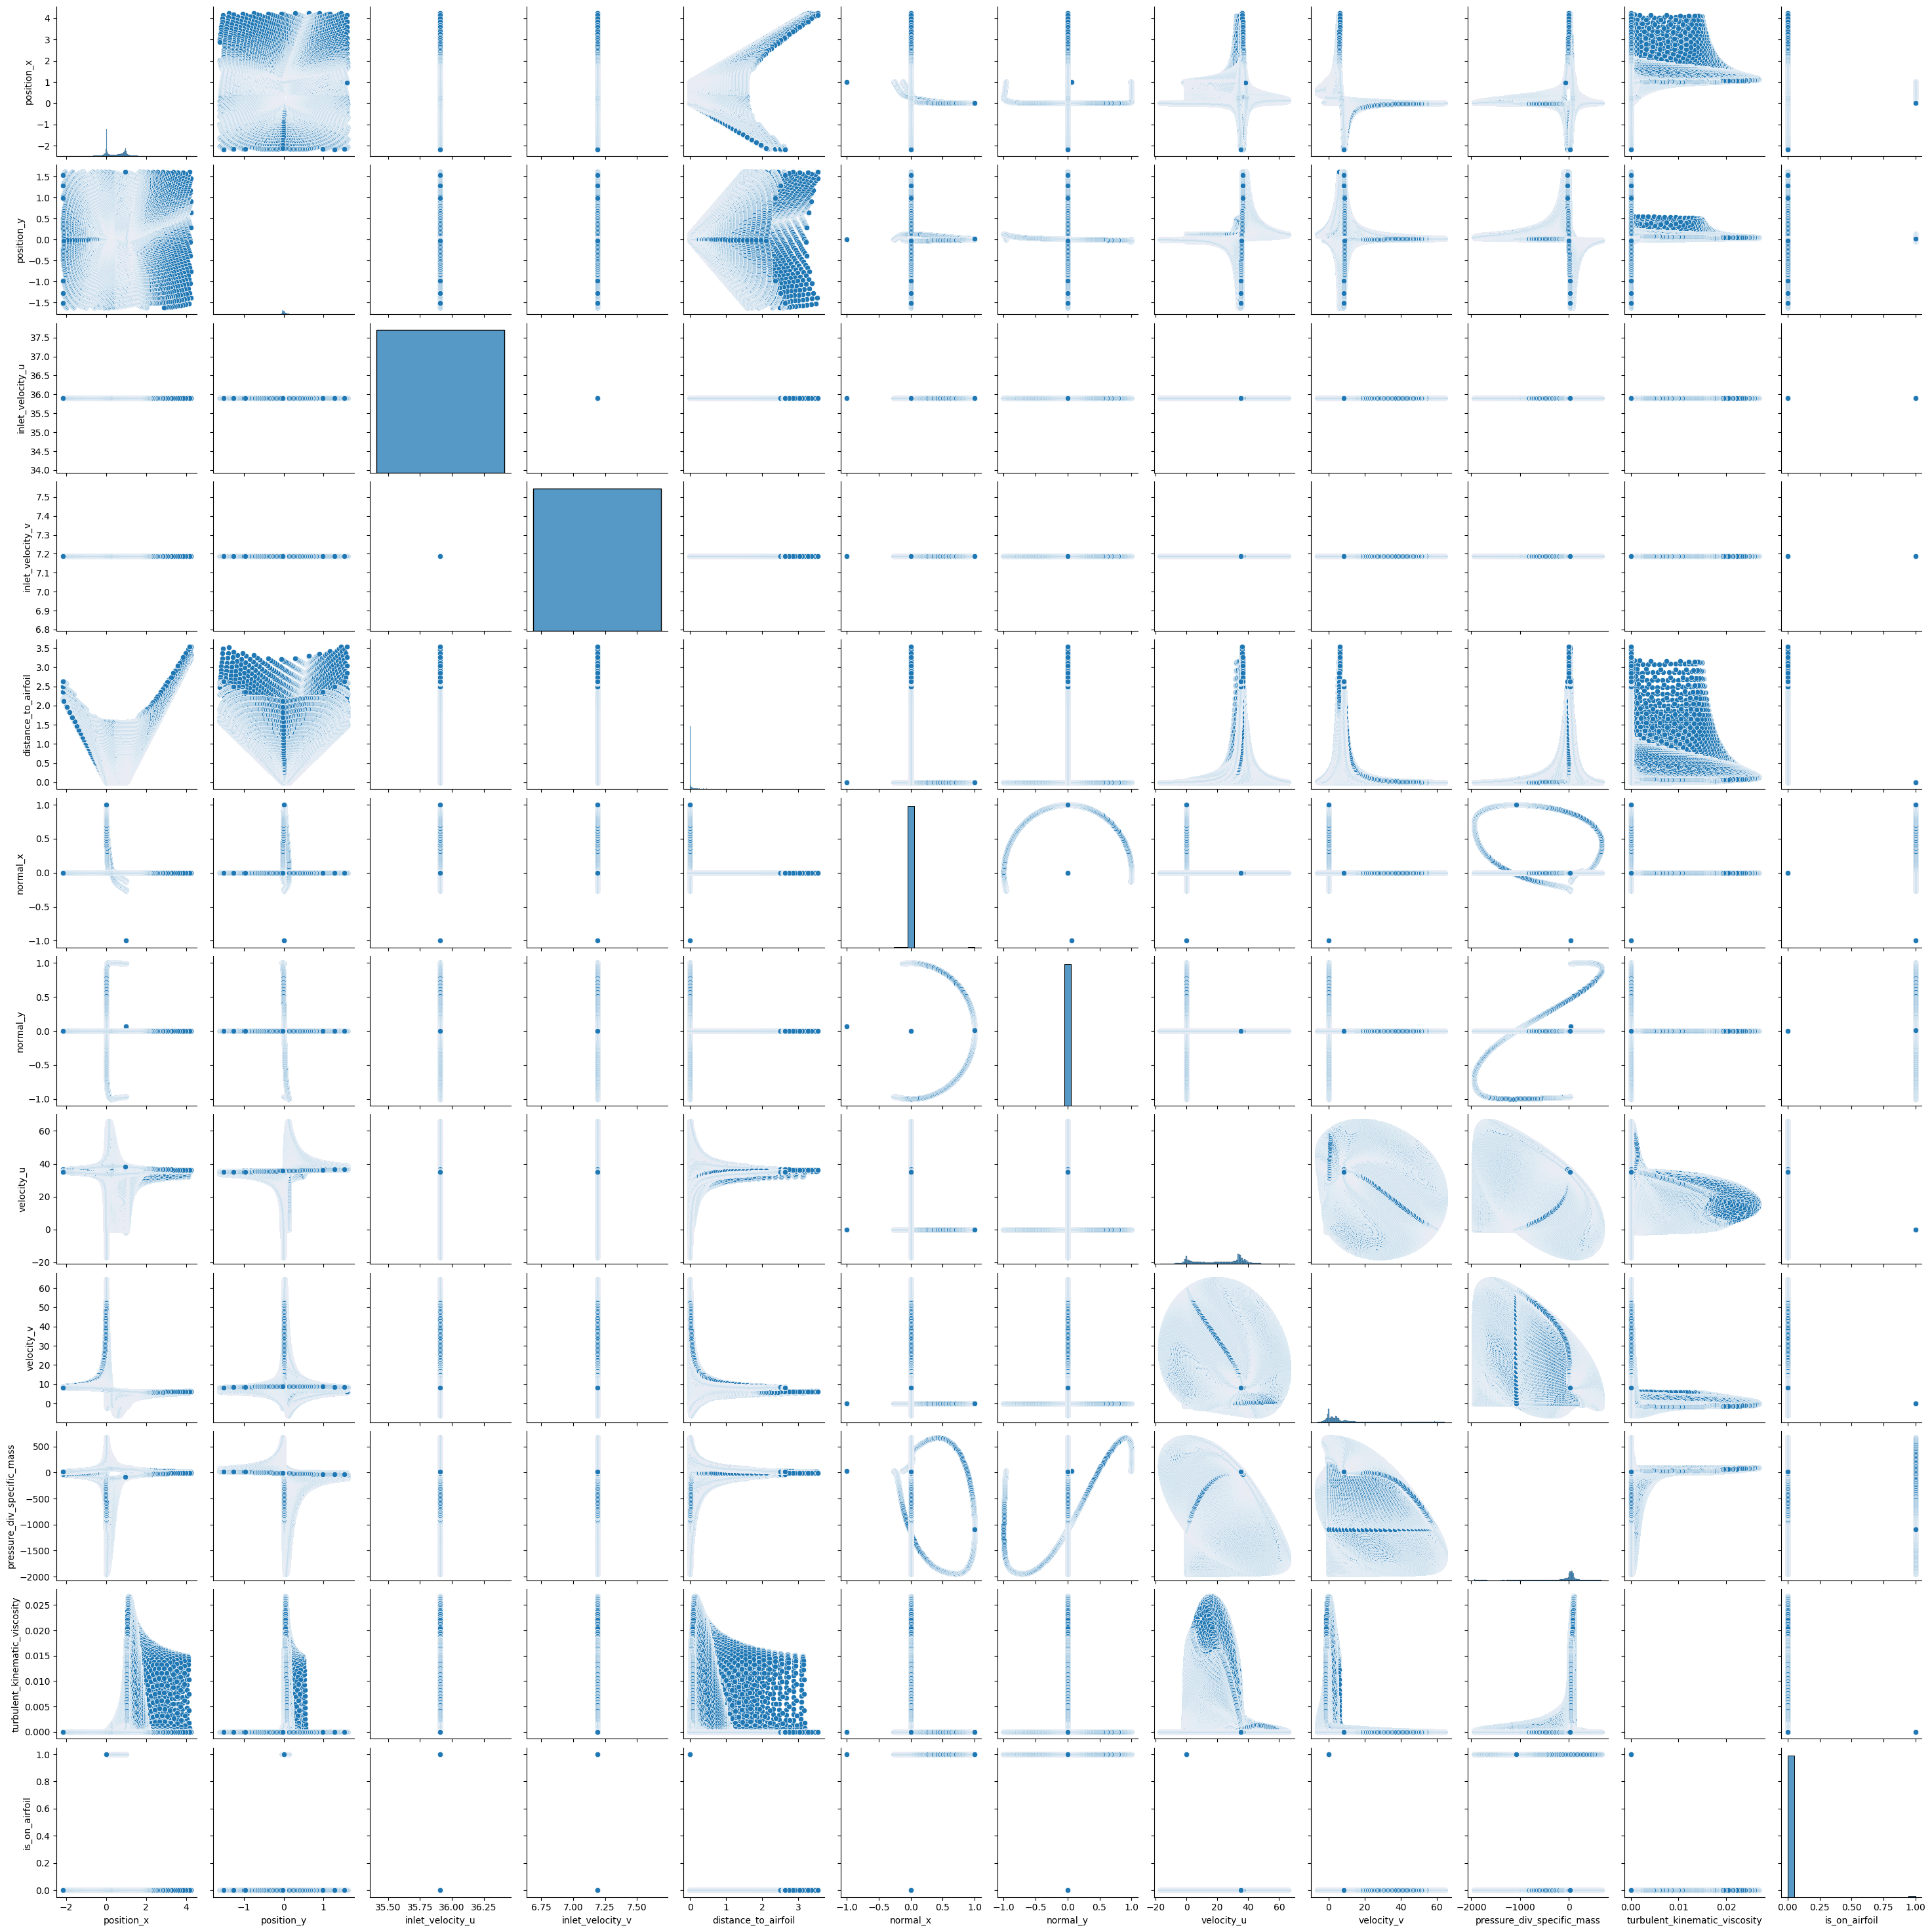

In [53]:
sns.pairplot(dataset_list[0])